# 01 - TF-IDF on the Governance Set
This notebook runs TF-IDF on the governance data set.

The code in this notebook was roughly based on [TF-IDF Vectorizer scikit-learn](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a) by Mukesh Chaudhary. We replicate their steps and build from there.

---
## Dependencies and Imports
This is where we install and import the dependencies. Most operations are performed using Scikit-learn ans Panda's. We also load Wordcloud and Matplotlib for visualising the word counts.

In [1]:
!pip install pandas scikit-learn wordcloud

In [2]:
import re
import sys
from pathlib import Path
WRITE='w'
READ_BINARY='rb'
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import numpy as np
print(f"numpy=={np.__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")


python==3.11.4
scikit-learn==1.2.2
pandas==2.0.2
numpy==1.25.0
wordcloud==1.9.2
matplotlib==3.7.1


---
## Data Loading
All data was preprocessed by the "_00 - Preprocess the Governance Data Set_" notebook, so our data loading steps here can be simplified. We don't have to worry about tokenization, stemming and stop words. For this notebook we really only need the DV data set and for comparison we load the complete corpus.

In [3]:
CACHE_DIR = '../cache/Governance'

# The Parquet files, gzipped.
ALL_PARQUET_GZ = CACHE_DIR + '/ALL_documents.parquet.gz'
DV_PARQUET_GZ  = CACHE_DIR + '/DV_documents.parquet.gz'

ALL_corpus = pd.read_parquet(ALL_PARQUET_GZ)
DV_corpus  = pd.read_parquet(DV_PARQUET_GZ)

# columns ofthe data set
DOCUMENT_BODY = 'body'
DOCUMENT_TITLE = 'Titel'
DOCUMENT_JAAR = 'Jaar'
MUNICIPALITY_CODE='GM_CODE'

DV_corpus


,body,GM_CODE,Titel,Jaar
index,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010
...,...,...,...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...,GM1945,Duurzaamheidsprogramma - Gemeente Berg en Dal,2013
GM1955DV01,milieuprogramma gemeente Montferland vaststell...,GM1955,Milieuprogramma 2014,2014
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...,GM1955,Zonne-energie in het buitengebied,0


For use in graphs, the Enexis and Google Sheets colour codes.

In [4]:
ENEXIS_PINK='#cc2b72'
ENEXIS_DARK_PINK='#a72a81'
ENEXIS_VERY_DARK_PINK='#942d88'
ENEXIS_GREEN='#c3da45'
ENEXIS_DARKGREEN='#94b950'
ENEXIS_LIGHTGREY='#f0f0f0'

SHEET_GREEN='#00b3ae'


---
## Document Frequency Tuning
The document frequency turned out to be a great way to clip off common (for the corpus) words from the data sets. More on that below. For now, we perform our TF-IDF analysis using the best values we found.

As our documents are quite large, we set `sublinear_tf` to apply a $log()$ to the TF. This reduces the significance of document size on the output.

*note*: the data type of `min_df` and `max_df` changes its meaning. `int`s are taken to mean counts, while `float`s are taken to mean percentages. We mix the two here, as you can see in the code below.

In [5]:
MIN_DF = 15   # count
MAX_DF = 0.85 # percent
SUBLINEAR_TF = True


---
## Apply Vectorizers to Governance Data Set
Here we define and run TF-IDF on the governance data sets. The count vectorizer is a good way to get some idea of how the documents and words relate. A better understanding of that helps with `max_df` and `min_df` tuning, for example.

The main reason to define these functions is to ensure the operations yield clean data frames for easy analysis.

In [6]:
def count_vectorize(series):
    vectorizer = CountVectorizer()

    # run the vectorizer on the data
    word_matrix = vectorizer.fit_transform(series)
    words_list = vectorizer.get_feature_names_out()

    # take the output and package it into various useful data frames
    per_document    = pd.DataFrame(index=series.index, columns=words_list, data=word_matrix.toarray())
    sum_over_corpus = pd.DataFrame(per_document.sum(), columns=['sum']).T

    return vectorizer, per_document, sum_over_corpus


def tfidf_vectorize(series, min_df, max_df, sublinear_tf):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, sublinear_tf=sublinear_tf)

    # run the vectorizer on the data
    word_matrix = vectorizer.fit_transform(series)
    words_list = vectorizer.get_feature_names_out()

    # take the output and package it into various useful data frames
    matrix = pd.DataFrame(index=series.index, columns=words_list, data=word_matrix.toarray())
    idf = pd.DataFrame(columns=words_list, data=[vectorizer.idf_])

    return vectorizer, matrix, idf


In [7]:
all_docs_vectorizer, all_docs_matrix, all_docs_idf = tfidf_vectorize(ALL_corpus[DOCUMENT_BODY], min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)
all_docs_matrix


,aaa,aachen,aal,aalburg,aalen,aalsmeer,aalt,aalten,aanaantonen,aanbe,...,zwerfafvalen,zwerfafvalvergoeding,zwerfaval,zwerfdieren,zwerfjongeren,zwerfvuil,zwerfvuilactie,zwijndrecht,zwolle,zzp
index,,,,,,,,,,,,,,,,,,,,,
GM0003DV02,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
GM0003EX06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.023718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
GM0003OB01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.017456
GM0003OB02,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
GM0005CA01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1987DV01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.055724,0.0,0.0,0.000000
GM1987IK01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
GM1987JS01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [8]:
#all_docs_vectorizer.stop_words_
len(all_docs_vectorizer.stop_words_)


317715

In [9]:
dv_docs_vectorizer, dv_docs_matrix, dv_docs_idf = tfidf_vectorize(DV_corpus[DOCUMENT_BODY], min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)
dv_docs_matrix


,aanbested,aanbesteding,aanbestedingen,aanbestedingsbeleid,aanbestedingstraject,aanbeveling,aanbieden,aanbieder,aanbieding,aanbod,...,zuidoost,zuinig,zuiniger,zuiveren,zuivering,zwaar,zwart,zwembad,zwerfafval,zwerfvuil
index,,,,,,,,,,,,,,,,,,,,,
GM0003DV02,0.00000,0.011961,0.000000,0.000000,0.000000,0.038088,0.029612,0.0,0.0,0.012241,...,0.0,0.032091,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GM0005DV01,0.00000,0.014458,0.000000,0.000000,0.000000,0.000000,0.012821,0.0,0.0,0.000000,...,0.0,0.025169,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.091655,0.000000
GM0007DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017467,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.015561,0.000000,0.000000,0.037044,0.049653
GM0009DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018100,0.0,0.0,0.035368,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.033804,0.000000,0.000000
GM0034DV01,0.00000,0.015308,0.028343,0.000000,0.000000,0.000000,0.013575,0.0,0.0,0.000000,...,0.0,0.015739,0.0,0.000000,0.031880,0.034670,0.036210,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0.00000,0.022688,0.017603,0.026454,0.045707,0.000000,0.014275,0.0,0.0,0.000000,...,0.0,0.016551,0.0,0.033125,0.000000,0.021533,0.000000,0.000000,0.000000,0.000000
GM1955DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022652,0.0,0.0,0.015440,...,0.0,0.000000,0.0,0.000000,0.000000,0.048157,0.000000,0.000000,0.000000,0.000000
GM1955DV02,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.026038,...,0.0,0.026160,0.0,0.000000,0.000000,0.000000,0.060182,0.000000,0.000000,0.000000


In [10]:
#dv_docs_vectorizer.stop_words_
len(dv_docs_vectorizer.stop_words_)


61024

### Dimensionality Reduction via `min_df` and `max_df` Tuning
In order to determine useful values for `min_df` and `max_df`. For that we need a histogram of the document frequency of each term.

In the dimensionality reduction we strive to remove words that are either not part of many documents (these are probably not on topic and likely to be spelling errors or specific to a certain municipality), or that are part of almost all documents. These do not contribute to the clustering and just end up making the clusters look very similar.

We arrived at the values for `MIN_DF` and `MAX_DF` by experimenting with a few word clouds, until we saw that the weasel words disappeared and the clusters started making sense.


In [11]:
DV_document_count = DV_corpus[DOCUMENT_BODY].shape[0]
max_df_line = int(DV_document_count * MAX_DF)

_, count_per_dv_document, _ = count_vectorize(DV_corpus[DOCUMENT_BODY])

histo_data = count_per_dv_document.astype(bool).sum(axis=ROW).sort_values()
histo_data[histo_data<MIN_DF].sample(10)


ndorpshuis                1
vloeroppervlakte          3
werksoort                 1
bodemkwaliteitsnormen     1
administratie            14
locatiesendergelijk       1
antoniuslaan              1
lawaaimaker               5
profieleninhet            1
kadervanpalet             1
dtype: int64

In [12]:
histo_data[histo_data>max_df_line].sample(10)


maken        244
woning       228
krijgen      228
openbaar     230
middel       229
onderdeel    222
moeten       237
partij       212
houden       233
regionaal    214
dtype: int64

min_df=15 and max_df=208 (85.0% of 245 documents)


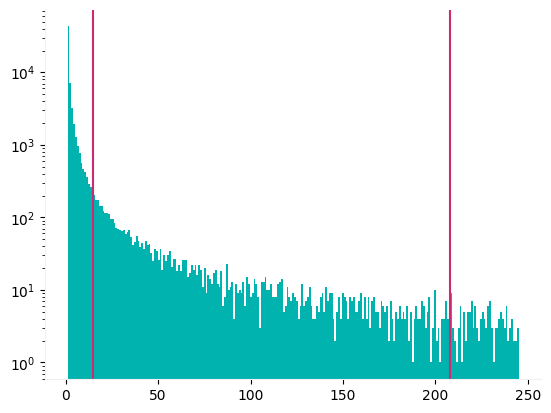

In [13]:
print(f"min_df={MIN_DF} and max_df={max_df_line} ({MAX_DF*100}% of {DV_document_count} documents)")

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.axvline(x=MIN_DF, color=ENEXIS_PINK, label=f"min_df={MIN_DF}")
ax.axvline(x=max_df_line, color=ENEXIS_PINK, label=f"max_df={max_df_line} ({MAX_DF*100}% of {DV_document_count} documents)")

ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_color(ENEXIS_LIGHTGREY)

# plt.legend(loc='upper right', fontsize=9)
plt.hist(histo_data, bins=DV_document_count, color=SHEET_GREEN);


In [14]:
count_per_dv_document


,aaa,aab,aachen,aachener,aadefg,aadijk,aagegee,aagehaakt,aageoe,aaissoy,...,zwollenaar,zwols,zzh,zzp,zzplen,zzprs,zzps,zzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,één
index,,,,,,,,,,,,,,,,,,,,,
GM0003DV02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
GM0005DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
GM0007DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
GM0009DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
GM0034DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
GM1955DV01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
GM1955DV02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [15]:
total_DV = dv_docs_matrix.mean().dropna().sort_values()
total_DV.nlargest(60)


eur                     0.026880
afval                   0.025437
wij                     0.025321
maatschappelijk         0.024759
programma               0.024265
water                   0.023697
communicatie            0.023533
mobiliteit              0.023155
natuur                  0.023151
actie                   0.023095
regio                   0.023033
concreet                0.023007
ondernemer              0.022950
ruimtelijk              0.022757
overheid                0.022732
vaststellen             0.022661
elektrisch              0.022420
extern                  0.022374
visie                   0.022369
economisch              0.022341
totaal                  0.022204
omgeving                0.022058
huidig                  0.022015
samenleving             0.021963
verlichting             0.021900
vervoer                 0.021837
uitvoeringsprogramma    0.021746
sociaal                 0.021714
klimaat                 0.021711
jaarlijks               0.021678
uitstoot  

---
## Word Cloud of Unique Words in DV vs All
Here we subtract the two word matrixes "all" and "dv" to determine what words are identifying for DV documents.

In [16]:
unique_for_DV = (dv_docs_matrix.mean() - all_docs_matrix.mean()).dropna().sort_values()
unique_for_DV.nlargest(20)


elektrisch              0.014955
uitstoot                0.014803
mobiliteit              0.014099
energieverbruik         0.013956
klimaat                 0.013722
energieneutraal         0.013414
warmte                  0.013275
afval                   0.013221
klimaatbeleid           0.013132
biomassa                0.013057
verduurzamen            0.012990
actie                   0.012845
verduurzaming           0.012695
zonnepanel              0.012512
opwekking               0.012139
energieakkoord          0.012089
energiezuinig           0.012005
zonne                   0.011983
energiegebruik          0.011976
uitvoeringsprogramma    0.011863
dtype: float64

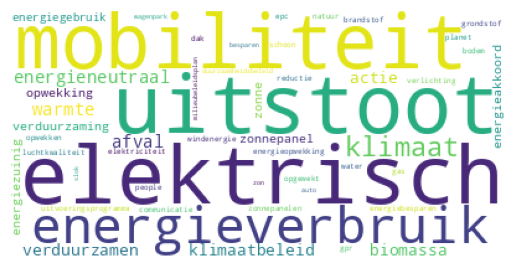

In [17]:
cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(unique_for_DV)
plt.axis('off')
plt.imshow(cloud);


In [18]:
unique_on_idf = (dv_docs_idf.T - all_docs_idf.T).dropna()
unique_on_idf[0].nlargest(20)

raming               1.770314
bijstand             1.602817
toevoeging           1.599545
transparantie        1.534512
vangen               1.486334
afwijking            1.477143
politie              1.472656
control              1.452941
ozb                  1.448972
woningmarkt          1.447456
transformatie        1.444416
besteding            1.433397
leerlingenvervoer    1.409152
arbeidmarkt          1.396942
doorontwikkeling     1.391870
kavel                1.384838
kwaliteitsniveau     1.381601
perceel              1.376019
overdracht           1.373465
zelfredzaamheid      1.372185
Name: 0, dtype: float64

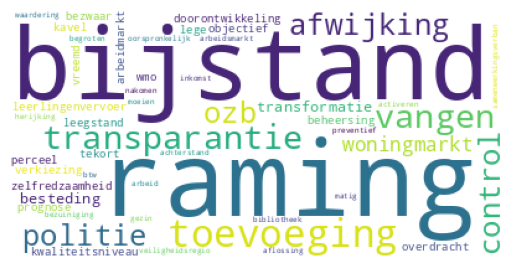

In [19]:
cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(unique_on_idf[0])
plt.axis('off')
plt.imshow(cloud);


In [20]:
dv_docs_idf.T[0].nlargest(10)


aang                 3.732743
aanname              3.732743
aantrekkingkracht    3.732743
aanwenen             3.732743
afgeven              3.732743
afspelen             3.732743
afvalstroom          3.732743
afwenteling          3.732743
algeheel             3.732743
alkmaar              3.732743
Name: 0, dtype: float64